In [173]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

In [174]:
sol = pd.read_csv('../out/solution.csv')
sol

,Year,Origin,Dest,NonStopKm,Passengers,city_origin,state_origin,pop_origin,city_dest,state_dest,pop_dest,construction_cost_usd,hsr_time_hr,flight_time_hr,co2_g_flight,co2_g_hsr,hash
0,2022,LAS,SNA,363.71084,790320.0,Las Vegas,NV,642798,Santa Ana,CA,341747,6.938966e+08,1.818554,0.909277,3.823058e+10,6.898751e+09,"frozenset({'SNA', 'LAS'})"
1,2022,LAS,LAX,379.80424,1423710.0,Las Vegas,NV,642798,Los Angeles,CA,3986442,7.246000e+08,1.899021,0.949511,7.191724e+10,1.297755e+10,"frozenset({'LAS', 'LAX'})"
2,2022,LAX,SFO,542.34758,1594150.0,Los Angeles,CA,3986442,San Francisco,CA,871042,1.034704e+09,2.711738,1.355869,1.149896e+11,2.075000e+10,"frozenset({'SFO', 'LAX'})"


In [175]:
cities_geom = gpd.read_file('../data/us-major-cities/USA_Major_Cities.shp')
cols = ['NAME', 'ST', 'geometry']
cities_geom[cols]


,NAME,ST,geometry
0,Ammon,ID,POINT (-111.95410 43.47579)
1,Blackfoot,ID,POINT (-112.34557 43.19394)
2,Boise City,ID,POINT (-116.23011 43.59901)
3,Burley,ID,POINT (-113.79329 42.53674)
4,Caldwell,ID,POINT (-116.68562 43.66163)
...,...,...,...
3881,Herndon,VA,POINT (-77.38672 38.96993)
3882,Highland Springs,VA,POINT (-77.32854 37.55172)
3883,Hollins,VA,POINT (-79.95348 37.34338)
3884,Hopewell,VA,POINT (-77.29837 37.29038)


In [176]:
sol_cols = sol.columns
sol_origin = sol.merge(cities_geom[cols], how='inner', left_on=['city_origin', 'state_origin'], right_on=['NAME', 'ST']).rename(columns={'geometry': 'pt_origin'})

sol_od = sol_origin.merge(cities_geom[cols], how='inner', left_on=['city_dest', 'state_dest'], right_on=['NAME', 'ST']).rename(columns={'geometry': 'pt_dest'})
sol_geom = sol_od[['pt_origin', 'pt_dest']]
sol_geom['geometry'] = sol_geom.apply(lambda row: shapely.LineString((row['pt_origin'], row['pt_dest'])), axis='columns')
sol_geom

/var/folders/v_/b1_tr5p9275_ry3qjq7b_pn00000gn/T/ipykernel_54555/132300525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_geom['geometry'] = sol_geom.apply(lambda row: shapely.LineString((row['pt_origin'], row['pt_dest'])), axis='columns')


,pt_origin,pt_dest,geometry
0,POINT (-115.13515 36.17648),POINT (-117.88186 33.73662),"LINESTRING (-115.135145976 36.17647644, -117.8..."
1,POINT (-115.13515 36.17648),POINT (-118.27058 34.05279),"LINESTRING (-115.135145976 36.17647644, -118.2..."
2,POINT (-118.27058 34.05279),POINT (-122.44245 37.76692),"LINESTRING (-118.270582264 34.0527896090001, -..."


<Axes: >

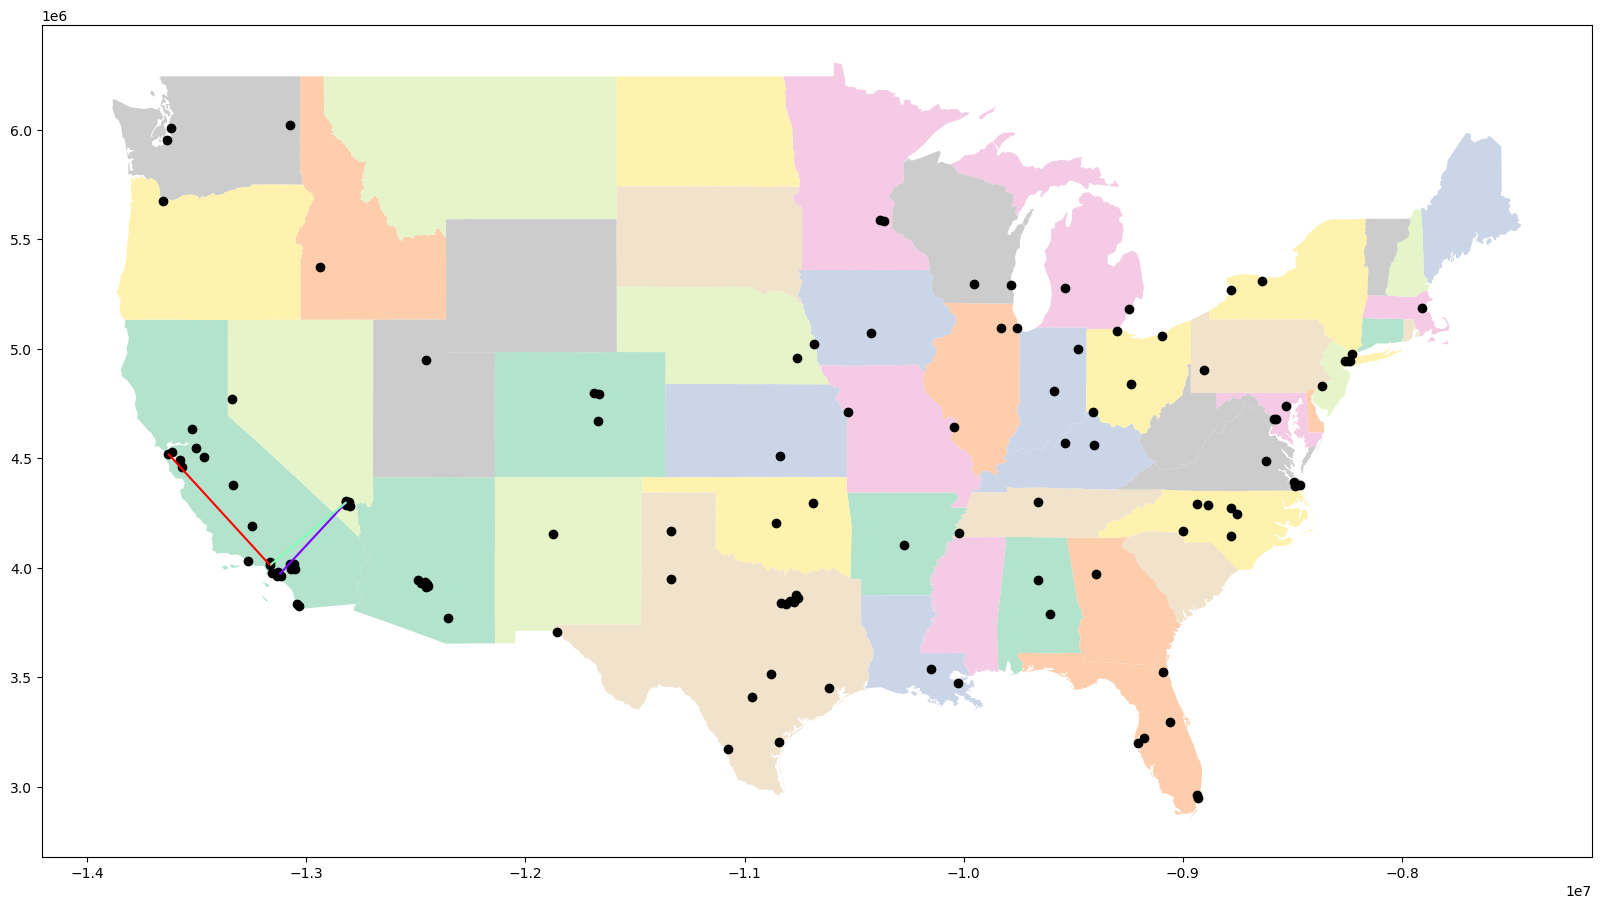

In [177]:
og_crs = cities_geom.crs
final = gpd.GeoDataFrame(sol, geometry=sol_geom['geometry'], crs=og_crs) # type: ignore
states = gpd.read_file('../data/us-states/States_shapefile.shp').to_crs(epsg=3395)
# remove AK and HI
states: gpd.GeoDataFrame = states[(states['State_Code'] != 'AK') & (states['State_Code'] != 'HI')] # type: ignore
citiesPlotMask = (cities_geom['POPULATION'] > 200e3) & (cities_geom['ST'] != 'HI') & (cities_geom['ST'] != 'AK')
cities_for_plot = cities_geom[citiesPlotMask].to_crs(epsg=3395)

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
ax1 = cities_for_plot.plot(ax=ax1, marker='o', color='black')
final.to_crs(epsg=3395).plot(ax=ax1, cmap='rainbow')

In [178]:
final['construction_cost_usd'].sum() / 1e9

2.4532009293145